### Objective:

Apply GPR to a discrete dynamical system.

## Method:

### Step 1: Formulation 
Let us again consider the toy problem that we considered earlier again.
The system is given by the equations:
$$
\begin{align}
    \frac{dx_1}{dt} &= x_2 -0.5*x_1 \\
    \frac{dx_2}{dt} &= sin(x_1)
\end{align}
$$

### Step2:  Actual solution of the equation
Let us again establish a solution of it numerically for completeness. And It will act as a good plotting and programming exercise.

In [435]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#Defining the function
def my_func(t,x):
    x1, x2 = x[0],x[1]
    dx_dt = np.zeros((2))
    dx_dt[0] = x2-0.5*x1
    dx_dt[1] = np.sin(x1)
    return dx_dt

#setting up the initial conditions
X0 = [-2,2]
X0 = np.array(X0)
t_span = [0,15]


#Integrating the ODE
int_func = solve_ivp(my_func,t_span, X0, dense_output=True)

# Data required for plotting
n_numsym = 1000
t = np.linspace(*t_span, n_numsym)
solution = int_func.sol(t)
x1 = solution[0,:]
x2 = solution[1,:]

### Step3: Collecting data
Now let us collect data with equal time spacing. We first collect n_train(here, 15) number of data points from the phase portrait which are equally spaced in time. Now using these 15 points we have to train the gpr. i.e, we will find a funcion that takes $x_1(t_n)$ and $x_2(t_n)$ as input to find $x_1(t_{n+1})$. We will find another gpr such that given $x_1(t_n)$ and $x_2(t_n)$ the gpr gives $x_2(t_{n+1})$

In [436]:
n_train = 15

#### (a) Code to collect equidistant data 
At any given time t we have the value of $(x_1,x_2)$ on the phase portrait. Our objective is collecting equidistant points from the phase portrait. I know the time span of the phase portrait(here 0 to 15). 

In [437]:
n_UD = n_train+1
#n_UT = number of uniformly spaced in time data points to construct uniformly spaced in distance.
n_UT = 10000
t_UT = np.linspace(*t_span,n_UT)
# getting n_UT number of equi time spaced datapoints from the phase portrait.
x_UT = int_func.sol(t_UT)
# getting the length of each equi time spaced line segment (ds).
x_UT_1 = x_UT[:,1:]
x_UT_2 = x_UT[:,0:-1]
dr = x_UT_1 - x_UT_2
ds = np.linalg.norm(dr,axis=0)
phaseport_length = np.sum(ds)
#find the distance between each equidistant datapoints.
segment_length = phaseport_length/(n_UD-1)
index=np.zeros(n_UD)
__=0
var_length=0
ii = 1
for _ in ds:
    var_length = var_length+_
    __=__+1 
    if var_length>= segment_length:
        var_length = 0
        index[ii]=__
        ii = ii+1
index[-1] = n_UT-1

index = index.astype(dtype=np.int32)

We have written a code to collect equi distant data points. Lets collect the data points.
#### (b) collecting equidistant data points
Since this is a discrete dynamical system, we will take 2 sets of data. 
1. The points on phase portrait at a time t.
2. The evolution of these points to the next time instance.

**@@NOTE@@**
A small modification in index. We have index containing n_train+1 indices. The last point in the phase portrait is considered as the last datapoint. But since we want to consider a discrete dynamical system, if we consider the last point we should consider another point beyond the last point so that the last point as input gives the point beyond as the output. To avoid this confusion, we will remove the last point from our training.

In [438]:
#index = index[0:-1]

In [439]:
t_train_1 = t_UT[index]
x_train = int_func.sol(t_train_1)
del_t = 0.2
t_train_2 = t_train_1+del_t
y_train = int_func.sol(t_train_2)

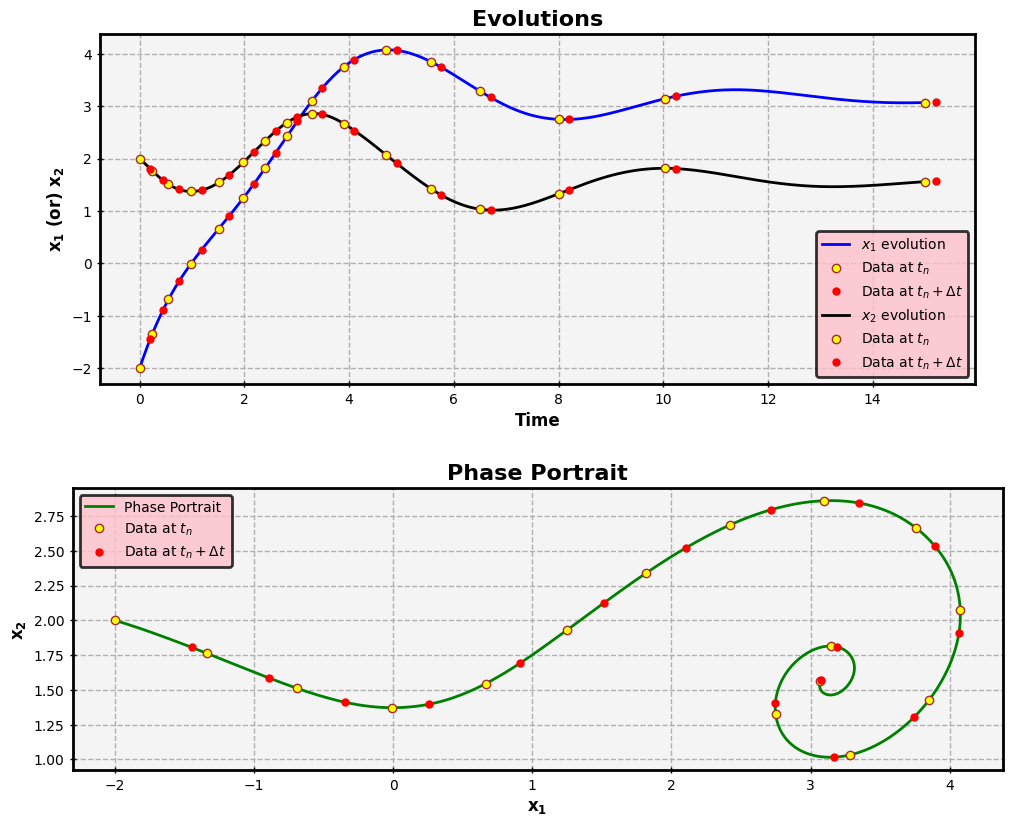

In [440]:
#plotting the curves
fig,axs = plt.subplots(2,1,figsize=(12,10))
axs[0].set_title("Evolutions",fontweight="bold", fontsize=16)
axs[1].set_title("Phase Portrait",fontweight="bold",fontsize=16)
axs[0].set_xlabel("Time", fontweight="bold",fontsize=12)
axs[0].set_ylabel("$\mathbf{x_1}$ (or) $\mathbf{x_2}$",fontweight="bold",fontsize=12)
axs[1].set_xlabel("$\mathbf{x_1}$ ",fontsize=12)
axs[1].set_ylabel("$\mathbf{x_2}$ ",fontsize=12)
axs[0].plot(t,x1,"b-",linewidth=2,label="${x_1}$ evolution")
axs[0].plot(t_train_1,x_train[0,:],color="brown", marker = "o", markeredgewidth=1, linestyle = "",
            markerfacecolor="yellow",linewidth=2,label="Data at $t_n$")
axs[0].plot(t_train_2,y_train[0,:],color="red", marker = "o",markersize = 5, markeredgewidth=1, linestyle = "",
            markerfacecolor="red",linewidth=2,label="Data at $t_n+\Delta t$")
axs[0].plot(t,x2, "k-", linewidth=2,label="${x_2}$ evolution")
axs[0].plot(t_train_1,x_train[1,:],color="brown", marker = "o", markeredgewidth=1, linestyle = "",
            markerfacecolor="yellow",linewidth=2,label="Data at $t_n$")
axs[0].plot(t_train_2,y_train[1,:],color="red", marker = "o",markersize = 5, markeredgewidth=1, linestyle = "",
            markerfacecolor="red",linewidth=2,label="Data at $t_n+\Delta t$")
axs[1].plot(x1,x2, "g-", linewidth=2,label="Phase Portrait")
axs[1].plot(x_train[0,:],x_train[1,:],color="brown", marker = "o", markeredgewidth=1, linestyle = "",
            markerfacecolor="yellow",linewidth=2,label="Data at $t_n$")
axs[1].plot(y_train[0,:],y_train[1,:],color="red", marker = "o",
            markersize = 5, markeredgewidth=1, linestyle = "",
            markerfacecolor="red",linewidth=2,label="Data at $t_n+\Delta t$")
#common aspects
for axs_num in [0,1]:
    axs[axs_num].grid("on",linestyle="--",linewidth=1)
    axs[axs_num].set_aspect("equal")
    #axs[(axs_num)].axis("equal")
    axs[axs_num].set_facecolor("#f4f4f4")
    legend = axs[axs_num].legend(loc="best",fontsize=10)
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor("black")
    legend.get_frame().set_facecolor("pink")
    spines_dict = ["top","bottom","left","right"]
    for spine_value in spines_dict:
        axs[axs_num].spines[spine_value].set_linewidth(2)
    axs[axs_num].tick_params(axis="both",direction="inout", length=5, width=1,labelsize=10)
plt.show()

### Preprocessing:
#### (a) Rearranging data as desired by sklearn
sklearn desires that the $x_1$ and $x_2$ are presented in column format.

In [441]:
x_train_s = np.transpose(x_train)

#### (b) Scaling the input
In the previous implementations, we appreciated the importance of scaling the data.The error of convergence was removed by rescaling! Hence before implementing GPR lets scale our input.

In [442]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train_s)
x_train_s = scaler.transform(x_train_s)

### GPR
#### (a) GPR to obtain $\mathbf{x_1(t_n+\Delta t)}$  given $\mathbf{x_1(t_n)}$ and $\mathbf{x_2(t_n)}$
Now the title of this setion is slightly decieving. We want to train the GP using  x_train and y_train such that the GPR when input with a point x in the phase portrait at time t, will give $x_1$ co-ordinate of the point at time $t+\Delta t$.


In [456]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF

length_scale_1 = [1,1]
length_scale_bounds_1 = [1e-5, 1e5]
kernel_1 = RBF(length_scale = length_scale_1, length_scale_bounds=length_scale_bounds_1)
gp_1 = GPR(kernel=kernel_1,n_restarts_optimizer=100,random_state=1)
gp_1.max_iter_predict = 10000000
gp_1.fit(x_train_s, y_train[0,:])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1]),
                         n_restarts_optimizer=100, random_state=1)

In [446]:
gp_1.kernel_

RBF(length_scale=[0.48, 2.92])

#### (b) GPR to obtain $\mathbf{x_2(t_n+\Delta t)}$  given $\mathbf{x_1(t_n)}$ and $\mathbf{x_2(t_n)}$

In [447]:
length_scale_2 = [1,1]
length_scale_bounds_2 = [1e-5, 1e5]
kernel_2 = RBF(length_scale = length_scale_2, length_scale_bounds=length_scale_bounds_2)
gp_2 = GPR(kernel=kernel_2,n_restarts_optimizer=100,random_state=1)
gp_2.max_iter_predict = 1000
gp_2.fit(x_train_s, y_train[1,:])

GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1]),
                         n_restarts_optimizer=100, random_state=1)

In [448]:
gp_2.kernel_

RBF(length_scale=[0.53, 0.849])

#### (c) Prediction
After we have performed GPR and estimated the hyperparameters, let us predict the phase portrait. Don't forget to scale the inputs. (I forgot to scale the inputs and wasted 1hr here)

In [449]:
# number of predictions required to cover the entire time span.
# number of predictions = t_span[2]/del_t 
n_preds = int(t_span[1]/del_t)
t_preds = np.arange(n_preds)*0.2
x1_mean_pred = np.zeros(n_preds)
x1_std_pred = np.zeros(n_preds)
x2_mean_pred =np.zeros(n_preds)
x2_std_pred = np.zeros(n_preds)
x1_mean_pred[0],x2_mean_pred[0]= X0
for _ in np.arange(n_preds-1):
    x1_t = x1_mean_pred[_]
    x2_t = x2_mean_pred[_]
    x_t = np.array([x1_t,x2_t])
    x_t = np.expand_dims(x_t,axis=0)
    x_t = scaler.transform(x_t)
    #x1_mean_pred[_+1]= gp_1.predict(x_t)
    #x2_mean_pred[_+1]= gp_2.predict(x_t)
    x1_mean_pred[_+1], x1_std_pred[_+1] = gp_1.predict(x_t, return_std=True)
    x2_mean_pred[_+1], x2_std_pred[_+1] = gp_2.predict(x_t, return_std=True)

In [450]:
x1_std_pred

array([0.00000000e+00, 9.99998931e-06, 4.70272809e-05, 4.92698022e-05,
       1.70198236e-05, 3.95672326e-05, 3.68540964e-05, 3.33958194e-05,
       1.61007788e-05, 1.37364946e-05, 1.47817716e-05, 1.00972604e-05,
       1.15426688e-05, 1.06139372e-05, 1.26442302e-05, 1.05719144e-05,
       1.59874183e-05, 1.23419986e-05, 1.83649059e-05, 3.25104921e-05,
       2.08102599e-05, 3.22886055e-05, 6.55544380e-05, 6.52627907e-05,
       2.57268969e-05, 5.23671285e-05, 1.10419607e-04, 1.27279976e-04,
       8.45418992e-05, 1.79798797e-05, 1.17926415e-04, 1.84831755e-04,
       1.71790550e-04, 7.10730343e-05, 9.00573420e-05, 2.56808376e-04,
       3.81513791e-04, 4.32608037e-04, 4.02255241e-04, 3.02085527e-04,
       1.55324471e-04, 1.58240790e-05, 1.74105292e-04, 3.11640896e-04,
       4.12152986e-04, 4.69024143e-04, 4.81064200e-04, 4.51317755e-04,
       3.85937624e-04, 2.93155609e-04, 1.82350368e-04, 6.34265349e-05,
       5.70363371e-05, 1.67087812e-04, 2.63196366e-04, 3.40875319e-04,
      

In [459]:
x2_std_pred

array([0.00000000e+00, 1.00000004e-05, 2.63943380e-04, 3.46773335e-04,
       1.28853046e-04, 2.69981607e-04, 6.79264738e-05, 2.40128028e-04,
       1.28636871e-04, 8.97931597e-05, 1.33322097e-04, 2.10596325e-05,
       1.18053698e-04, 2.02664366e-05, 1.41033346e-04, 2.64114244e-05,
       2.24502385e-04, 1.59113112e-04, 2.82082678e-04, 6.15714860e-04,
       3.82635932e-04, 4.14698784e-04, 1.13417431e-03, 1.20405491e-03,
       4.90335917e-04, 6.01101259e-04, 1.44697447e-03, 1.59475768e-03,
       9.41155679e-04, 2.36526992e-04, 1.38209653e-03, 1.94647718e-03,
       1.64456445e-03, 6.02433878e-04, 7.61033052e-04, 1.96497278e-03,
       2.69554272e-03, 2.84943561e-03, 2.49228889e-03, 1.77774950e-03,
       8.82915532e-04, 4.21862019e-05, 8.35162347e-04, 1.44489705e-03,
       1.82151478e-03, 1.96489448e-03, 1.90413205e-03, 1.68538813e-03,
       1.36070322e-03, 9.79387213e-04, 5.82628807e-04, 2.01709326e-04,
       1.49634796e-04, 4.49114095e-04, 6.99122989e-04, 8.97931416e-04,
      

We observe that the standard deviations are really small. Now lets plot our predictions with respect to the data considered and the actual ground truth.

### Plots

In [452]:
t_preds.size

75

In [453]:
x1_mean_pred.size

75

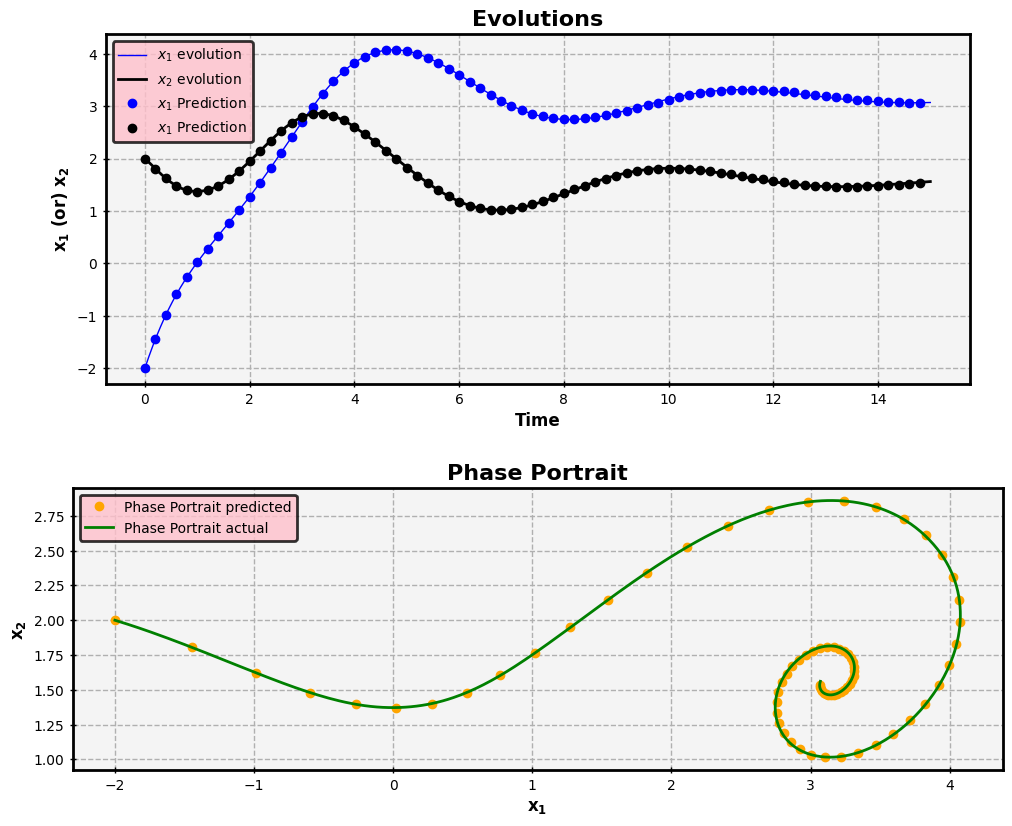

In [454]:
#plotting the curves
fig,axs = plt.subplots(2,1,figsize=(12,10))
axs[0].set_title("Evolutions",fontweight="bold", fontsize=16)
axs[1].set_title("Phase Portrait",fontweight="bold",fontsize=16)
axs[0].set_xlabel("Time", fontweight="bold",fontsize=12)
axs[0].set_ylabel("$\mathbf{x_1}$ (or) $\mathbf{x_2}$",fontweight="bold",fontsize=12)
axs[1].set_xlabel("$\mathbf{x_1}$ ",fontsize=12)
axs[1].set_ylabel("$\mathbf{x_2}$ ",fontsize=12)

axs[0].plot(t,x1,"b-",linewidth=1,label="${x_1}$ evolution")
# axs[0].plot(t_train_1,x_train[0,:],color="brown", marker = "o", markeredgewidth=1, linestyle = "",
#             markerfacecolor="yellow",linewidth=2,label="Data at $t_n$")
# axs[0].plot(t_train_2,y_train[0,:],color="red", marker = "o",markersize = 5, markeredgewidth=1, linestyle = "",
#             markerfacecolor="red",linewidth=2,label="Data at $t_n+\Delta t$")
axs[0].plot(t,x2, "k-", linewidth=2,label="${x_2}$ evolution")
# axs[0].plot(t_train_1,x_train[1,:],color="brown", marker = "o", markeredgewidth=1, linestyle = "",
#             markerfacecolor="yellow",linewidth=2,label="Data at $t_n$")
# axs[0].plot(t_train_2,y_train[1,:],color="red", marker = "o",markersize = 5, markeredgewidth=1, linestyle = "",
#             markerfacecolor="red",linewidth=2,label="Data at $t_n+\Delta t$")
axs[0].plot(t_preds,x1_mean_pred,"bo",linewidth=1,label="${x_1}$ Prediction")
axs[0].plot(t_preds,x2_mean_pred,"ko",linewidth=1,label="${x_1}$ Prediction")

axs[1].plot(x1_mean_pred,x2_mean_pred, "orange",marker="o",linestyle= "", linewidth=2,label="Phase Portrait predicted")
axs[1].plot(x1,x2, "green", linewidth=2,label="Phase Portrait actual")
# axs[1].plot(x_train[0,:],x_train[1,:],color="brown", marker = "o", markeredgewidth=1, linestyle = "",
#             markerfacecolor="yellow",linewidth=2,label="Data at $t_n$")
# axs[1].plot(y_train[0,:],y_train[1,:],color="red", marker = "o",
#             markersize = 5, markeredgewidth=1, linestyle = "",
#             markerfacecolor="red",linewidth=2,label="Data at $t_n+\Delta t$")
#common aspects
for axs_num in [0,1]:
    axs[axs_num].grid("on",linestyle="--",linewidth=1)
    axs[axs_num].set_aspect("equal")
    #axs[(axs_num)].axis("equal")
    axs[axs_num].set_facecolor("#f4f4f4")
    legend = axs[axs_num].legend(loc="best",fontsize=10)
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor("black")
    legend.get_frame().set_facecolor("pink")
    spines_dict = ["top","bottom","left","right"]
    for spine_value in spines_dict:
        axs[axs_num].spines[spine_value].set_linewidth(2)
    axs[axs_num].tick_params(axis="both",direction="inout", length=5, width=1,labelsize=10)
plt.show()